Load and clean the raw data

In [77]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from os.path import join
import datetime
import string
import network_creation_functions as ncf
from importlib import reload

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Read all the data

In [78]:
src = '../../data/raw'

In [79]:
! ls ../../data/raw

course_dates.csv	exam_dates.csv	      missing_study_names.csv
course_enrollment.csv	exam_enrollment.csv   rooms.csv
courses.csv		exam_supervision.csv  students.csv
course_supervision.csv	lecturers.csv	      study_labels.csv


In [80]:
# List of students with enrolled studies. A student can have more than one study,
# which will show up as separate entries (row) for the same student_id. Each
# study also has a term number, i.e. the number of semesters the student has
# been enrolled in the given study.
students = pd.read_csv(join(src, 'students.csv'))

# Mapping of lecturers to organisations (institute, faculty). A lecturer can
# be associated with more than one organisation.
lecturers = pd.read_csv(join(src, 'lecturers.csv'))

# List of lectures with information about their type, their name, their module
# (this is only relevant for how studies are composed at TU Graz) and the 
# organisational unit (institute, faculty) which is responsible for the lecture.
courses = pd.read_csv(join(src, 'courses.csv'))

# List of enrolled students for courses in the WiSe 2019/20. A courses
# can have several groups (for example for tutorial parts). The group enrollment
# is also listed for every student. It is not completely unique
# as there are a number of overlapping groups (for example same time, 
# different rooms). These are disambiguated at a later point in the data
# cleaning process. The data also includes the identifier of the study through 
# which the student enrolled in a given lecture. 
course_enrollment = pd.read_csv(join(src, 'course_enrollment.csv'))

# List of enrolled students for exams in the WiSe 2019/20.
exam_enrollment = pd.read_csv(join(src, 'exam_enrollment.csv'))

# List of lecturers which are responsible for lectures and groups within
# lectures. Similar to the course enrollment table, the group_id is 
# disambiguated later in the data cleaning process
course_supervision = pd.read_csv(join(src, 'course_supervision.csv'))

# List of lecturers which are responsible for exams. Similar to the course 
# enrollment table, the exam_id is disambiguated later in the data cleaning 
# process
exam_supervision = pd.read_csv(join(src, 'exam_supervision.csv'))

# Courses (start time, end time, room) for every course and group in WiSe 
# 2019/20
course_dates = pd.read_csv(join(src, 'course_dates.csv'), 
                           parse_dates=["date", "start_time", "end_time"])

# Exams (start time, end time, room) for every exam in WiSe 2019/20
exam_dates = pd.read_csv(join(src, 'exam_dates.csv'), 
                           parse_dates=["date"])

# List of rooms and information about them (number of seats, square meters).
# TU Graz has three campuses: Alte Technik, Neue Technik and Inffeldgasse. The
# mapping of every room to a campus is also stored.
# Information for rooms outside TU Graz premises was missing. Jana Lasser 
# manually searched for and filled in room information for rooms at Uni Graz 
# and added the information to the file /data/raw/Räume.csv. The updated file 
# is stored in /data/cleaned/Räume_cleaned.csv. These rooms are excluded from
# the further analysis anyways though.
rooms = pd.read_csv(join(src, 'rooms.csv'))

# Cleaning summary

| data | cleaning | checks |
| ---- | -------- | ------ |
| course dates | dropped: dates outside normal hours, dates longer than 13 hours | no dates outside the semester |
| exam dates | dropped: dates outside normal hours, dates without a start time, dates longer than 13 hours| no dates outside the semester, all exams have a supervising lecturer |
| course enrollment | dropped: enrollments without dates |
| exam enrollment | dropped: enrollments without dates |
| courses | dropped: courses without enrollment |
| students | dropped: students without enrollments in courses or exams |
| course supervision | dropped: lecturers who don't supervise a course or exam |
| exam supervision | dropped: lecturers who don't supervise a course or exam |
| lecturers | dropped: organisations without active lecturers |
| rooms | dropped: rooms without courses or exams |





## Event dates 

### Drop all course & exam dates occur inside the semester

In [81]:
# date of the semester start
semester_start = pd.to_datetime(ncf.semester_start)
# date of the semester end
semester_end = pd.to_datetime(ncf.semester_end)

# Make sure all events take place within the time specified by the semester
# start (2019-10-01) and semester end (2020-02-28).
assert len(course_dates) == len(course_dates[course_dates['date'] >= semester_start])
assert len(course_dates) == len(course_dates[course_dates['date'] <= semester_end])

# Make sure all events take place within the time specified by the semester
# start (2019-10-01) and semester end (2020-02-28).
assert len(exam_dates) == len(exam_dates[exam_dates['date'] >= semester_start])
assert len(exam_dates) == len(exam_dates[exam_dates['date'] <= semester_end])

### Drop course dates that occured outside normal lecture hours

In [82]:
# convert the start and end datetime to a time and drop all courses
# which occured outside normal lecture hours, i.e. had a start time
# before 7:00 AM, after 8:00 PM or at exactly midnight (not covered
# by either of the two conditions). We assume these courses are either
# erroneous entries or placeholder courses.
course_dates['start_time'] = course_dates['start_time'].dt.time
course_dates['end_time'] = course_dates['end_time'].dt.time
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] <= datetime.time(20, 0)]
print('dropped {}/{} courses with a start time later than 8:00 PM'\
      .format(N - len(course_dates), N))
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] >= datetime.time(7, 0)]
print('dropped {}/{} courses with a start time earlier than 7:00 AM'\
      .format(N - len(course_dates), N))
N = len(course_dates)
course_dates = course_dates[course_dates['start_time'] >= datetime.time(0, 0)]
print('dropped {}/{} courses with a start time at 00:00'\
      .format(N - len(course_dates), N))

dropped 31/29147 courses with a start time later than 8:00 PM
dropped 133/29116 courses with a start time earlier than 7:00 AM
dropped 0/28983 courses with a start time at 00:00


### Drop exams without start time

In [83]:
N = len(exam_dates)
exam_dates = exam_dates.dropna(subset=["start_time"])
print('dropped {}/{} exams without start time'\
      .format(N - len(exam_dates), N))
N = len(exam_dates)
print('{} ({:1.2f}%) exams do not have an end time'\
      .format(N - len(exam_dates["end_time"].dropna()), 
              (N - len(exam_dates["end_time"].dropna())) / N * 100))

print('{} ({:1.2f}%) exams do not have an assigned room'\
      .format(N - len(exam_dates["room_id"].dropna()), 
              (N - len(exam_dates["room_id"].dropna())) / N * 100))

dropped 144/5633 exams without start time
2745 (50.01%) exams do not have an end time
3517 (64.07%) exams do not have an assigned room


### Merge course and exam dates to event dates

In [84]:
exam_dates = exam_dates.rename(columns={"exam_id":"group_id"})

In [85]:
def get_time(timestring):
    if timestring != timestring:
        return np.nan
    else:
        hour, minute = timestring.split(':')
        return datetime.time(int(hour), int(minute))

In [86]:
# convert the start and end time string to a time object
exam_dates['start_time'] = exam_dates['start_time']\
    .apply(get_time)
exam_dates['end_time'] = exam_dates['end_time']\
    .apply(get_time)

In [87]:
event_dates = pd.concat([course_dates, exam_dates])
event_dates = event_dates.reset_index(drop=True)
del course_dates
del exam_dates

### Drop events with duration > 780 minutes

In [88]:
# Calculate the duration of events and drop all events that have a duration
# of more than 13 hours. We assume these events are either erroneous entries 
# or placeholder events.
event_dates['duration'] = event_dates.apply(ncf.calculate_duration, axis=1)
duration_threshold = 13 * 60

def nan_leq(duration):
    '''Returns true in the duration is <= duration_threshold or NaN'''
    if duration != duration:
        return True
    elif duration <= duration_threshold:
        return True
    else:
        return False
    
N = len(event_dates) 
event_dates = event_dates[event_dates['duration'].apply(nan_leq)]
print("dropped {}/{} events that were longer than {} minutes"\
      .format(N - len(event_dates), N, duration_threshold))

dropped 2/34472 events that were longer than 780 minutes


## Enrollment

### Merge course and exam enrollments

In [89]:
exam_enrollment = exam_enrollment.rename(columns={"exam_id":"group_id"})
enrollment = pd.concat([course_enrollment, exam_enrollment])
enrollment = enrollment.reset_index(drop=True)
del course_enrollment
del exam_enrollment

### Drop event enrollments without dates

In [90]:
group_IDs = set(event_dates["group_id"])

N = len(enrollment)
enrollment = enrollment[enrollment["group_id"].isin(group_IDs)]
print('dropped {}/{} enrollments without dates'\
      .format(N - len(enrollment), N))

dropped 5859/143320 enrollments without dates


### Drop events dates without enrollments

In [91]:
group_IDs = set(enrollment["group_id"])

N = len(event_dates)
event_dates = event_dates[event_dates["group_id"].isin(group_IDs)]
print('dropped {}/{} event dates without enrollment'\
      .format(N - len(event_dates), N))

dropped 4917/34470 event dates without enrollment


In [92]:
diff = set(event_dates["group_id"].unique()).difference(set(enrollment["group_id"].unique()))
assert len(diff) == 0

## Supervision

### Drop course supervision entries without enrollment

In [93]:
# filter out lecturers without courses
N = len(course_supervision["lecturer_id"].unique())
course_supervision = course_supervision[course_supervision["group_id"].isin(group_IDs)]
print('dropped {}/{} course supervisions with no enrollment in supervised event'\
      .format(N - len(course_supervision["lecturer_id"].unique()), N))

dropped 465/1853 course supervisions with no enrollment in supervised event


### Drop exam supervision entries without enrollment

In [94]:
# filter out lecturers without courses
N = len(exam_supervision["lecturer_id"].unique())
exam_supervision = exam_supervision[exam_supervision["exam_id"].isin(group_IDs)]
print('dropped {}/{} exam supervisions with no enrollment in supervised exam'\
      .format(N - len(exam_supervision["lecturer_id"].unique()), N))

dropped 20/870 exam supervisions with no enrollment in supervised exam


### Merge course and exam supervision

In [95]:
exam_supervision = exam_supervision.rename(columns={"exam_id":"group_id"})
supervision = pd.concat([course_supervision, exam_supervision])
supervision = supervision.reset_index(drop=True)
del course_supervision
del exam_supervision

## Groups

In [96]:
# convert group IDs to string format, because we are going to add letters to
# them for disambiguation
enrollment["group_id"] = enrollment["group_id"].astype(int).astype(str)
event_dates["group_id"] = event_dates["group_id"].astype(int).astype(str)
supervision["group_id"] = supervision["group_id"].astype(int).astype(str)

In [97]:
groups = enrollment[['course_id', 'group_id']].drop_duplicates().copy()
groups = groups[groups['group_id'].isin(event_dates['group_id'].unique())]
groups = groups.reset_index(drop=True)

### Disambiguate group IDs for events

In [98]:
def deduplicate_group(date):
    '''
    Checks whether for a given group id and date there is more than one
    event at the same time. If this is the case, the group ID is split into a
    number of subgroups equal to the number of events that take place at the
    same time. This is done by adding a letter (from "a" to "z") to the group
    ID. Mappings of datetime indices in the event_date data frame to new group 
    IDs are returned as a data frame.
    '''
    new_group_ids = pd.DataFrame()
    curr_date = event_dates[event_dates["date"] == date]
    for group_id in curr_date['group_id']:
        # dates that happen at the same time for the same group
        group_dates = event_dates[(event_dates['group_id'] == group_id) & \
                            (event_dates['date'] == date)]
        # is there more than one date for the same group id on a given day?
        # do the duplicate dates start at the same time?
        if (len(group_dates) > 1) and \
           (len(group_dates['start_time'].drop_duplicates()) < len(group_dates)):
            
            # de-duplicate group ids stat start at the same time by adding a 
            # letter at the end of the id
            for dt in group_dates['datetime']:
                group_datetimes = group_dates[group_dates['datetime'] == dt]
                assert len(group_datetimes) <= len(letter_list)
                
                for index, letter in zip(group_datetimes.index, letter_list):
                    #event_dates.loc[index, 'new_group_id'] = '{}{}'.format(group_id, letter)
                    new_group_ids = new_group_ids.append({
                        "index":index,
                        "new_group_id":f'{group_id}{letter}'
                    }, ignore_index=True)
                    
    return new_group_ids

In [99]:
# create a temporary datetime entry for easy checking if something happens on
# the same day at the same time
event_dates["datetime"] = event_dates\
    .apply(lambda x: datetime.datetime.combine(x['date'], x['start_time']), axis=1)

# list of letters to append to create new group IDs
letter_list = list(string.ascii_lowercase)

# do this on many cores to speed it up
pool = Pool(15)
dates = event_dates['date'].unique()
new_group_ids = pd.DataFrame()
for IDs in tqdm(
        pool.imap_unordered(func=deduplicate_group, iterable=dates), total=len(dates)
    ):
    new_group_ids = pd.concat([new_group_ids, IDs])

100%|██████████| 128/128 [00:15<00:00,  8.02it/s]


In [100]:
# replace the old group IDs with the new group IDs on the given 
# datetimes (indices)
new_group_ids["index"] = new_group_ids["index"].astype(int)
event_dates["new_group_id"] = event_dates["group_id"]
event_dates.loc[new_group_ids["index"].values, "new_group_id"] = \
    new_group_ids["new_group_id"].values

In [101]:
# create a list of groups that were split into subgroups for convenience
group_splits = event_dates[event_dates[['group_id', 'new_group_id']]\
            .apply(lambda x: x["group_id"] != x["new_group_id"], 1)]\
            [["group_id", "new_group_id"]].drop_duplicates()
print('{} groups had more than one date on the same day and at the same time '\
      .format(len(group_splits['group_id'].unique())) + \
     'and were split into {} new groups'.format(len(group_splits)))

166 groups had more than one date on the same day and at the same time and were split into 409 new groups


### Assign new group IDs to enrollment

In [102]:
# We create new enrollment entries for students that are distributed into the
# new subgroups. This is needed because some groups are only split into
# subgroups on certain dates, while they take place as a single group on other
# dates. Therefore for one group there might be events that are assigned to the
# original group ID, while other events are assigned to the new group IDs.
new_enrollment = pd.DataFrame()

# Some new groups are not used, because there are not enough students enrolled
# in the original group to populate all new subgroups. We record these unused
# groups and remove them from the event_date table later.
unused_new_group_IDs = []

# iterate over all groups that were split into subgroups and distribute student
# enrollment evenly between the new subgroups
for group_id in group_splits['group_id'].unique():
    # identify all students that were enrolled in the original group
    students_in_group = enrollment[enrollment['group_id']  == group_id]
    # fetch the newly disambiguated group IDs
    new_group_ids = group_splits[\
            group_splits['group_id'] == group_id]['new_group_id'].values
    # calculate how many students will be allocated in each of the subgroups
    new_group_size = int(len(students_in_group) / len(new_group_ids))
    
    # make sure the new groups have each at least one student
    if new_group_size >= 1:
    
        # distribute the new students equally to the subgroups
        for i, ID in enumerate(new_group_ids[0:-1]):
            tmp = students_in_group[\
                    i * new_group_size:(i + 1) * new_group_size].copy()
            tmp['group_id'] = ID
            new_enrollment = pd.concat([new_enrollment, tmp])
        tmp = students_in_group[(i + 1) * new_group_size:].copy()
        tmp['group_id'] = new_group_ids[-1]
        new_enrollment = pd.concat([new_enrollment, tmp])
        
    # if this is not the case, assign one student each to the first N subgroups,
    # where N is the number of available students. Record the rest of the
    # subgroups as "unused" to be deleted later
    else:
        print("WARNING: found a case where there are fewer students than groups!")
        print(f"{len(students_in_group)} students for {len(new_group_ids)} new groups")
        for ID, index in zip(new_group_ids, students_in_group.index):
            tmp = students_in_group.loc[index].copy()
            tmp['group_id'] = ID
            new_enrollment = new_enrollment.append(tmp, ignore_index=True)
               
        tmp = new_group_ids[len(students_in_group):]
        print(f"adding {len(tmp)} new groups to the list of unused groups")
        unused_new_group_IDs.extend(tmp)
        
# add the new enrollment information to the enrollment table
enrollment = pd.concat([enrollment, new_enrollment]).reset_index(drop=True)

1 students for 2 new groups
adding 1 new groups to the list of unused groups
1 students for 6 new groups
adding 5 new groups to the list of unused groups


In [103]:
# remove unused (because of lack of students) new groups again
group_splits = group_splits\
    .drop(group_splits[group_splits["new_group_id"].isin(unused_new_group_IDs)].index)\
    .reset_index(drop=True)

# drop event dates for unused groups
event_dates = event_dates\
    .drop(event_dates[event_dates["new_group_id"].isin(unused_new_group_IDs)].index)\
    .reset_index(drop=True)

event_dates["group_id"] = event_dates["new_group_id"]
event_dates = event_dates.drop(columns=["new_group_id", "datetime"])

In [104]:
# drop enrollments for groups that were entirely replaced by new groups
group_IDs = set(event_dates["group_id"].unique())
N = len(enrollment["group_id"].unique())
enrollment = enrollment[enrollment["group_id"].isin(group_IDs)]
print("dropped {} original group IDs that were completely replaced by new group IDs"\
     .format(N - len(enrollment["group_id"].unique())))

dropped 55 original group IDs that were completely replaced by new group IDs


In [105]:
diff = set(event_dates["group_id"].unique()).difference(set(enrollment["group_id"].unique()))
assert len(diff) == 0
diff = set(enrollment["group_id"].unique()).difference(set(event_dates["group_id"].unique()))
assert len(diff) == 0

### Assign new group IDs to supervision

In [106]:
new_supervision = pd.DataFrame()
lonely_groups = 0

for group_id in group_splits['group_id'].unique():
    lecturers_in_group = supervision[supervision['group_id']  == group_id]
    new_group_ids = group_splits[group_splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(lecturers_in_group) / len(new_group_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_group_size == 1:
        lonely_groups += 1
    
    # distribute the new students equally to the subgroups
    for i, ID in enumerate(new_group_ids[0:-1]):
        tmp = lecturers_in_group[\
                i * new_group_size:(i + 1) * new_group_size].copy()
        tmp['group_id'] = ID
        new_supervision = pd.concat([new_supervision, tmp])
    tmp = lecturers_in_group[(i + 1) * new_group_size:].copy()
    tmp['group_id'] = new_group_ids[-1]
    new_supervision = pd.concat([new_supervision, tmp])
    
print('{} split groups have no lecturer now'.format(lonely_groups))

# add the new supervision information to the supervision table
supervision = pd.concat([supervision, new_supervision]).reset_index(drop=True)

81 split groups have no lecturer now


In [107]:
# drop supervision for groups that were entirely replaced by new groups
group_IDs = set(event_dates["group_id"].unique())
N = len(supervision["group_id"].unique())
supervision = supervision[supervision["group_id"].isin(group_IDs)]
print("dropped {} original group IDs that were completely replaced by new group IDs"\
     .format(N - len(supervision["group_id"].unique())))

dropped 55 original group IDs that were completely replaced by new group IDs


In [108]:
# all supervised groups have event dates
diff = set(supervision["group_id"].unique()).difference(set(event_dates["group_id"].unique()))
assert len(diff) == 0

In [109]:
diff = set(event_dates["group_id"].unique()).difference(set(supervision["group_id"].unique()))
N_lonely_groups = len(event_dates[event_dates["group_id"].isin(diff)]["group_id"].unique())
print(f"{N_lonely_groups} groups have no supervision")

112 groups have no supervision


In [110]:
groups = enrollment[['course_id', 'group_id']].drop_duplicates().copy()
groups = groups[groups['group_id'].isin(event_dates['group_id'].unique())]
groups = groups.reset_index(drop=True)
groups.head(2)

,course_id,group_id
0,226598,260636
1,221416,258125


## Courses

### Merge courses and exams into course table

In [111]:
only_exam_courses = pd.DataFrame({"course_id":event_dates[~event_dates["course_id"]\
                        .isin(courses["course_id"])]["course_id"].unique()})

only_exam_courses["course_name"] = np.nan
only_exam_courses["course_type"] = "EX"
courses = pd.concat([courses, only_exam_courses])
courses = courses.reset_index(drop=True)
del only_exam_courses

### Drop courses without enrollment

In [112]:
course_IDs = groups["course_id"].unique()
N = len(courses)
courses = courses[courses["course_id"].isin(course_IDs)]
print('dropped {}/{} courses without enrollment'\
      .format(N - len(courses["course_id"].unique()), N))

dropped 4581/7542 courses without enrollment


In [113]:
event_dates = event_dates.drop(columns=["course_id"])
supervision = supervision.drop(columns=["course_id"])
enrollment = enrollment.drop(columns=["course_id"])

## Students

In [114]:
# create a temporary student + study identifier
enrollment["student_study"] = enrollment.apply(lambda x: x["student_id"] + "_" + x["study_id"], axis=1)
students["student_study"] = students.apply(lambda x: x["student_id"] + "_" + x["study_id"], axis=1)

### Add missing student + study from enrollment to student table

In [115]:
diff = set(enrollment["student_study"]).difference(set(students["student_study"]))
missing_students = enrollment[enrollment["student_study"].isin(diff)]\
    [["student_id", "study_id", "student_study"]].copy()
missing_students["study_name"] = np.nan
missing_students["term_number"] = np.nan
students = pd.concat([students, missing_students]).reset_index(drop=True)
print(f"added {len(missing_students)} student + study combinations from enrollment to the student table")

added 80420 student + study combinations from enrollment to the student table


### Drop student + study without enrollment from student table

In [116]:
N = len(students)
students = students[students["student_study"].isin(enrollment["student_study"])]
print(f" removed {N - len(students)} student + study combination without enrollment from the student table")

 removed 15525 student + study combination without enrollment from the student table


### Drop duplicate student + study combinations from student table

In [117]:
N = len(students)
students = students.drop_duplicates(subset=["student_study"])
print(f" removed {N - len(students)} student + study duplicates from the student table")

 removed 42328 student + study duplicates from the student table


In [118]:
assert len(set(enrollment["student_study"]).difference(set(students["student_study"]))) == 0
assert len(set(students["student_study"]).difference(set(enrollment["student_study"]))) == 0

In [119]:
assert len(set(enrollment["student_id"]).difference(set(students["student_id"]))) == 0
assert len(set(students["student_id"]).difference(set(enrollment["student_id"]))) == 0

In [120]:
assert len(set(enrollment["study_id"]).difference(set(students["study_id"]))) == 0
assert len(set(students["study_id"]).difference(set(enrollment["study_id"]))) == 0

In [121]:
students = students.drop(columns=["student_study"])
enrollment = enrollment.drop(columns=["student_study"])

## Lecturers

### Drop lecturers without active supervision

In [122]:
# filter out lecturers without courses
lecturer_IDs = set(supervision["lecturer_id"])
N = len(lecturers["lecturer_id"].unique())
lecturers = lecturers[lecturers["lecturer_id"].isin(lecturer_IDs)]
print('dropped {}/{} lecturers without supervision of course or exam'\
      .format(N - len(lecturers["lecturer_id"].unique()), N))

dropped 3922/5302 lecturers without supervision of course or exam


### Add missing supervising lecturers to lecturer table

In [123]:
diff = set(supervision["lecturer_id"]).difference(set(lecturers["lecturer_id"]))
missing_lecturers = supervision[supervision["lecturer_id"].isin(diff)][["lecturer_id"]].copy()
missing_lecturers["organisation_name"] = np.nan
lecturers = pd.concat([lecturers, missing_lecturers]).reset_index(drop=True)

In [124]:
lecturers = lecturers.drop_duplicates()

In [125]:
assert len(set(lecturers["lecturer_id"]).difference(set(supervision["lecturer_id"]))) == 0
assert len(set(supervision["lecturer_id"]).difference(set(lecturers["lecturer_id"]))) == 0

## Rooms

### Drop rooms without courses or exams

In [126]:
event_dates["room_id"] = event_dates["room_id"].replace({-999999.0:np.nan})
rooms["room_id"] = rooms["room_id"].astype(int)
room_IDs = set(event_dates["room_id"].dropna().astype(int))

In [127]:
N = len(rooms["room_id"].unique())
rooms = rooms[rooms["room_id"].isin(room_IDs)]
print('dropped {}/{} rooms without courses or exams'\
      .format(N - len(rooms["room_id"].unique()), N))

# make sure there are no duplicate rooms
assert len(rooms) == len(rooms["room_id"].unique())
print(f"{len(rooms)} rooms remaining")

dropped 1902/2288 rooms without courses or exams
386 rooms remaining


### Add missing rooms to room table

In [128]:
# rooms for which there is no information in the room table
set(room_IDs).difference(rooms["room_id"])

{18955, 19956, 22368, 22408, 29134, 29135}

In [129]:
# found in KFU room search system
room1 = {"room_id":18955, "seats":np.nan, "area":159, "campus":"KFU",
 "address":"Universitätsplatz 1", "postal_code":8010, "city":"Graz"}

# found in KFU room search system
room2 = {"room_id":19956, "seats":130, "area":147, "campus":"KFU",
 "address":"Heinrichstraße 36", "postal_code":8010, "city":"Graz"}

# found in KFU room search system
room3 = {"room_id":22368, "seats":105, "area":62, "campus":"KFU",
 "address":"Universitätsplatz 5", "postal_code":8010, "city":"Graz"}

# somehwere in the institute for Electronics
room4 = {"room_id":22408, "seats":np.nan, "area":np.nan, "campus":"Inffeldgasse",
 "address":"Heinrichstraße 36", "postal_code":8010, "city":"Graz"}

# found and measured by hand in TU Graz online room search system
room5 = {"room_id":29134, "seats":np.nan, "area":51, "campus":"Alte Technik",
 "address":"Technikerstraße 4", "postal_code":8010, "city":"Graz"}

# not found in TU or KFU
room6 = {"room_id":29135, "seats":np.nan, "area":np.nan, "campus":np.nan,
 "address":np.nan, "postal_code":8010, "city":"Graz"}

rooms = rooms.append([room1, room2, room3, room4, room5, room6], ignore_index=True)

In [130]:
assert len(set(event_dates["room_id"].dropna()).difference(set(rooms["room_id"]))) == 0
assert len(set(rooms["room_id"]).difference(set(event_dates["room_id"]))) == 0

### Fix room address encodings

In [131]:
address_map = {
    'Lessingstraï¿½e 25':'Lessingstraße 25',
    'Rechbauerstraï¿½e 12':'Rechbauerstraße 12',
    'Technikerstraï¿½e 4':'Technikerstraße 4',
    'UniversitÃ¤tsplatz 1':'Universitätsplatz 1', 
    'UniversitÃ¤tsstraÃ\x9fe 15':'Universitätsstraße 15',
    'Mï¿½nzgrabenstraï¿½e 35A':'Münzgrabenstraße 35A',
    'HeinrichstraÃ\x9fe 36':'Heinrichstraße 36',
    'Mandellstraï¿½e 11':'Mandellstraße 11',
    'Mandellstraï¿½e 13':'Mandellstraße 13',
    'UniversitÃ¤tsplatz 6':'Universitätsplatz 6',
    'HeinrichstraÃ\x9fe 28':'Heinrichstraße 28',
    'Lessingstraï¿½e 27':'Lessingstraße 27'
}

In [132]:
rooms["address"] = rooms["address"].replace(address_map)

### Fix room missing entries

In [133]:
rooms["postal_code"] = 8010
rooms["city"] = 'Graz'

## Data enrichment

### Add missing study names

In [134]:
study_names = students[["study_id", "study_name"]].dropna().drop_duplicates()
# missing mapping of study IDs to study names compiled by hand through google
# searches
missing_study_names = pd.read_csv(join(src, "missing_study_names.csv"))
study_names = pd.concat([study_names, missing_study_names])
study_name_map = {row["study_id"]:row["study_name"] for i, row in study_names.iterrows()}
students["study_name"] = students["study_id"].map(study_name_map)

### Add study levels

In [135]:
study_map = ncf.study_map # mapping of studies to degree levels

In [136]:
# the text before the semicolon in the study_name field describes (approximately) 
# the degree and is mapped to a unified pre / post graduate degree scheme that was
# informed by Timotheus Hell
def get_study_level(study_name):
    if study_name != study_name:
        return np.nan
    else:
        return study_map[study_name.split(';')[0]]

students['study_level'] = students['study_name'].apply(get_study_level)
students.head(2)

,student_id,study_id,study_name,term_number,study_level
15,ekijKawygVR8ULF1NZTkbY7vnKPhz22,UF 033 282,Bachelorstudium; Wirtschaftsingenieurwesen-Mas...,11.0,bachelor
22,aThq4hjnVcaKTvBw7BoN0daZD7PZ1wi,UF 033 243,Bachelorstudium; Architektur,1.0,bachelor


### Add study university labels (TU & NAWI)

In [137]:
# TU Graz offers a wide variety of studies. Some of them in cooperation with
# other local universities, such as Uni Graz, the university of arts and
# teaching studies (organised Austria-wide). The vast majority of these
# collaborative studies are organised under the umbrella of "NaWi Graz"
# (NaturWissenschaften Graz), in cooperation with Uni Graz. 

# Students who are enrolled in one of these collaboratively organised studies
# have a high chance of having the majority of their classes at the premises 
# of other universities. We therefore assign the studies to a total of 6
# labels, indicating which university they belong to. This will later enable
# us to filter by study and exclude students which are not enrolled in 
# native TU Graz studies.

# study labels (supplied by Timotheus Hell):
# "t": TU Graz study
# "n": NaWi Graz study (study with uni Graz)
# "l": teaching study (study with 8 other universities)
# "k": study with university of arts
# "w": further training courses
# "a": other university (includes non-NaWi studies with Uni Graz, former "u" label)
study_labels = pd.read_csv(join('../../data/raw', 'study_labels.csv'))
label_map = {row['study_id']:row['study_label'] for i, row in \
            study_labels.iterrows()}
students['study_label'] = students['study_id'].map(label_map)

### Add main study

In [138]:
# Students can have more than one study. Find a student's main study
# by looking at the study id of the individual events they visit.
# A student's main study in the given semester is the study from which
# the majority of their visited events stems.
group_counts = enrollment[['student_id', 'study_id', 'group_id']]\
    .groupby(by=['student_id', 'study_id'])\
    .agg('count')\
    .rename(columns={'group_id':'group_count'})\
    .sort_values(by='group_count', ascending=False)\
    .reset_index()
main_studies = group_counts[['student_id', 'study_id']]\
    .drop_duplicates(subset=['student_id'])\
    .set_index('student_id')

students["main_study"] = students["student_id"]\
    .apply(lambda x: main_studies.loc[x, "study_id"])

### Impute event durations

In [139]:
# We want to impute missing event durations specific for each event type.
# For this purpose, we add course type information to the event_dates data table
groups = groups.set_index("group_id")
courses = courses.set_index("course_id")

event_dates["course_id"] = event_dates["group_id"].apply(lambda x: groups.loc[x])
event_dates["course_type"] = event_dates["course_id"].apply(lambda x: courses.loc[x, "course_type"])

In [140]:
# impute event durations based on event type
event_dates["imputed_duration"] = False
event_dates["imputed_end_time"] = False
for course_type in event_dates["course_type"].unique():
    course_type_events = event_dates[event_dates["course_type"] == course_type]
    median_duration = course_type_events["duration"].median()
    N = len(course_type_events)
    print("{} (N={}): missing {:1.3f}%, median duration {:1.3f} min"\
          .format(course_type,
                  len(course_type_events),
                  (N - len(course_type_events["duration"].dropna())) / N * 100,
                  median_duration))
    
    
    event_dates.loc[course_type_events.index, "duration"] = median_duration
    event_dates.loc[course_type_events["duration"].isna().index, "imputed_duration"] = True
    event_dates.loc[course_type_events["duration"].isna().index, "imputed_end_time"] = True

# calculate end times for events with imputed durations
event_dates["end_time"] = event_dates.apply(ncf.calculate_end_time, axis=1)

VU (N=4712): missing 4.435%, median duration 120.000 min
LU (N=1803): missing 7.543%, median duration 240.000 min
VO (N=9349): missing 3.615%, median duration 105.000 min
SE (N=3179): missing 12.551%, median duration 105.000 min
UE (N=6076): missing 4.460%, median duration 90.000 min
KV (N=99): missing 7.071%, median duration 60.000 min
PT (N=166): missing 26.506%, median duration 120.000 min
KU (N=588): missing 5.272%, median duration 105.000 min
PV (N=765): missing 3.399%, median duration 90.000 min
SP (N=171): missing 60.819%, median duration 60.000 min
OL (N=63): missing 12.698%, median duration 90.000 min
RU (N=8): missing 12.500%, median duration 90.000 min
RP (N=5): missing 0.000%, median duration 120.000 min
EX (N=2562): missing 45.667%, median duration 120.000 min
PR (N=1): missing 0.000%, median duration 60.000 min


### Impute room areas

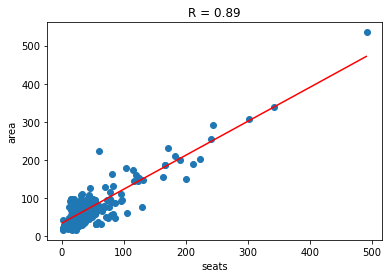

In [141]:
subset = rooms[["seats", "area"]].dropna().copy()
subset["area"] = subset["area"].astype(float)
subset["seats"] = subset["seats"].astype(int)
subset["area_per_seat"] = subset["area"] / subset["seats"]

good_seat_info = subset[subset["area_per_seat"] > 0.5]
bad_seat_info = subset[subset["area_per_seat"] <= 0.5]

fig, ax = plt.subplots()
ax.scatter(good_seat_info["seats"], good_seat_info["area"])
ax.set_xlabel("seats")
ax.set_ylabel("area")

cor = good_seat_info[["area", "seats"]].corr().loc["area", "seats"]

# since we have both cases with existing seat info but missing area info and
# existing area info but missing seat info, we do both regressions to recover
# the coefficients
slope_seats, intercept_seats, rvalue, pvalue, stderr = \
    linregress(good_seat_info["seats"], good_seat_info["area"])

slope_area, intercept_area, rvalue, pvalue, stderr = \
    linregress(good_seat_info["area"], good_seat_info["seats"])

x = np.arange(1, good_seat_info["seats"].max())
y = intercept_seats + slope_seats * x
ax.plot(x, y, color="red")
ax.set_title("R = {:1.2f}".format(cor));

In [142]:
rooms["imputed_area"] = False
rooms["imputed_seats"] = False

In [143]:
# impute areas of rooms with existing but most likely faulty area information
print(f"imputing {len(bad_seat_info)} rooms with bad area info using information from {len(good_seat_info)} trustworthy rooms")
rooms.loc[bad_seat_info.index, "area"] = \
    round(bad_seat_info["seats"] * slope_seats + intercept_seats, 1)
rooms.loc[bad_seat_info.index, "imputed_area"] = True

# impute areas of rooms with missing area information
missing_areas = rooms[(rooms["area"].isna()) & (~rooms["seats"].isna())].index
print(f"imputing {len(missing_areas)} rooms with missing areas")
rooms.loc[missing_areas, "area"] = \
    round(rooms.loc[missing_areas, "seats"] * slope_seats + intercept_seats, 1)
rooms.loc[missing_areas, "imputed_area"] = True

# impute seats of rooms with missing seat information
rooms["area"] = rooms["area"].astype(float)
missing_seats = rooms[(rooms["seats"].isna()) & (~rooms["area"].isna())].index
print(f"imputing {len(missing_seats)} rooms with missing seats")
rooms.loc[missing_seats, "seats"] = \
    (rooms.loc[missing_seats, "area"] * slope_area + intercept_area).astype(int)
rooms.loc[missing_seats, "imputed_seats"] = True

# impute the rest of the rooms where both seats and areas are missing with the
# median values of areas and seats of the most trustworthy part of the data
missing_everything = rooms[rooms["seats"].isna()].index
print(f"imputing {len(missing_everything)} rooms with both missing area and missing seats")
rooms.loc[missing_everything, "seats"] = rooms.loc[good_seat_info.index, "seats"].median()
rooms.loc[missing_everything, "imputed_seats"] = True
rooms.loc[missing_everything, "area"] = rooms.loc[good_seat_info.index, "area"].median()
rooms.loc[missing_everything, "imputed_area"] = True

imputing 104 rooms with bad area info using information from 230 trustworthy rooms
imputing 49 rooms with missing areas
imputing 3 rooms with missing seats
imputing 6 rooms with both missing area and missing seats


## Resolve space-time continuum problems

Many students are enrolled in events that take place at the same time. Since students can't clone themselves, they have to decide for an event to participate in. The same is true for lecturers who are assigned to supervise more than one event at the same time. In the following, we resolve these duplicate attendances following a simple heuristic: Students give priority to events from their main study, and to exams. If the priority of two conflicting events is the same, the event that starts earlier takes precedent. If both events start at the same time, a random event is chosen.  

For lecturers, events that start earlier take precedent. If two conflicting events start at the same time, a random event is chosen.

### Event participation

In [ ]:
# add information about the main study to the enrollment data. This is needed
# to make decisions about which event the student should participate in. The
# information is dropped again later.
main_studies = students[["student_id", "main_study"]].drop_duplicates().copy()
main_studies = main_studies.set_index("student_id")

enrollment["main_study"] = enrollment\
    .apply(lambda x: x.study_id == main_studies.loc[x.student_id], axis=1)

In [ ]:
dst1 = "../../data/clean/"
dst2 = "../../data/"

all_days = list(event_dates['date'].unique())
all_days = [pd.to_datetime(sd) for sd in all_days]
all_days.sort()

In [156]:
def get_day_participation(student_id):
    '''
    Given a student id, determine which events the student is enrolled in and
    which they will actually participate in, avoiding overlaps between events.
    When selecting events, priority is given in the following order:
    exam from main study > exam > course from main study > course. If two 
    overlapping events have the same priority, the event that starts earlier
    takes precedent.
    '''
    
    tmp_event_participations = pd.DataFrame()
    
    # get the events the given student is enrolled in
    student_day_enrollment = day_enrollment[\
            day_enrollment["student_id"] == student_id]
    
    # determine the starting and ending times of the events, sort them by
    # starting time in ascending order
    student_day_times = day_events[\
        day_events["group_id"].isin(student_day_enrollment["group_id"])]\
        .sort_values(by="start_time", ascending=True)
    
    # easy case: only one enrollment on the given day
    if len(student_day_enrollment) == 1:
        tmp_event_participations = tmp_event_participations.append({
            "student_id":student_id,
            "group_id":student_day_times["group_id"].values[0],
            "date":date,
            "start_time":student_day_times["start_time"].values[0],
            "end_time":student_day_times["end_time"].values[0]
        }, ignore_index=True)
        
    # more than one enrollment on the given day - potential overlap
    else:
        # split into courses from the main and secondary studies
        main_study_courses = student_day_enrollment[\
            student_day_enrollment["main_study"] == True]["group_id"].values
        main_study_day_times = student_day_times[\
            student_day_times["group_id"].isin(main_study_courses)]
        sec_study_day_times = student_day_times[\
            ~student_day_times["group_id"].isin(main_study_courses)]
        
        # split courses further into exams and non-exams
        main_study_day_exams = main_study_day_times[\
            main_study_day_times["course_type"] == "EX"]
        sec_study_day_exams = sec_study_day_times[\
            sec_study_day_times["course_type"] == "EX"]
        main_study_day_courses = main_study_day_times[\
            main_study_day_times["course_type"] != "EX"]
        sec_study_day_courses = sec_study_day_times[\
            sec_study_day_times["course_type"] != "EX"]
        
        # start with exams associated with the main study
        if len(main_study_day_exams) > 0:
            tmp_event_participations = tmp_event_participations.append({
                "student_id":student_id,
                "group_id":main_study_day_exams["group_id"].values[0],
                "date":date,
                "start_time":main_study_day_exams["start_time"].values[0],
                "end_time":main_study_day_exams["end_time"].values[0]
            }, ignore_index=True)
            
        if len(main_study_day_exams) > 1:
                tmp_event_participations = ncf.determine_event_participation(
                    main_study_day_exams.iloc[1:], 
                    tmp_event_participations,
                    student_id, date
                )
                    
        # continue with other exams
        if len(sec_study_day_exams) > 0:
            # no event participations yet? Add the first non-main study exam
            # to the event participation list without checking overlap
            if len(tmp_event_participations) == 0:
                tmp_event_participations = tmp_event_participations.append({
                    "student_id":student_id,
                    "group_id":sec_study_day_exams["group_id"].values[0],
                    "date":date,
                    "start_time":sec_study_day_exams["start_time"].values[0],
                    "end_time":sec_study_day_exams["end_time"].values[0]
                }, ignore_index=True)
                
                # check for overlap for the remaining non-main study exams
                if len(sec_study_day_exams) > 1:
                    tmp_event_participations = ncf.determine_event_participation(
                        sec_study_day_exams.iloc[1:], 
                        tmp_event_participations,
                        student_id, date
                    )
            # if there already is a participation recorded for the day, check
            # overlap for all non-main study exams
            else:
                tmp_event_participations = ncf.determine_event_participation(
                    sec_study_day_exams, 
                    tmp_event_participations,
                    student_id, date
                )
                
        # resolve attendance in main study courses first
        if len(main_study_day_courses) > 0:
            # no event participations yet? Add the first main study course
            # to the event participation list without checking overlap
            if len(tmp_event_participations) == 0:
                tmp_event_participations = tmp_event_participations.append({
                    "student_id":student_id,
                    "group_id":main_study_day_courses["group_id"].values[0],
                    "date":date,
                    "start_time":main_study_day_courses["start_time"].values[0],
                    "end_time":main_study_day_courses["end_time"].values[0]
                }, ignore_index=True)

                # check for overlap for the remaining main study courses
                if len(main_study_day_courses) > 1:
                    tmp_event_participations = ncf.determine_event_participation(
                        main_study_day_courses.iloc[1:], 
                        tmp_event_participations,
                        student_id, date
                    )
            # if there already is a participation recorded for the day, check
            # overlap for all main study courses
            else:
                tmp_event_participations = ncf.determine_event_participation(
                    main_study_day_courses, 
                    tmp_event_participations,
                    student_id, date
                )
        
        # resolve attendance in non-main study courses last
        if len(sec_study_day_courses) > 0:
            # no event participations yet? Add the first non-main study course
            # to the event participation list without checking overlap
            if len(tmp_event_participations) == 0:
                tmp_event_participations = tmp_event_participations.append({
                    "student_id":student_id,
                    "group_id":sec_study_day_courses["group_id"].values[0],
                    "date":date,
                    "start_time":sec_study_day_courses["start_time"].values[0],
                    "end_time":sec_study_day_courses["end_time"].values[0]
                }, ignore_index=True)

                # check for overlap for the remaining non-main study courses
                if len(sec_study_day_courses) > 1:
                    tmp_event_participations = ncf.determine_event_participation(
                        sec_study_day_courses.iloc[1:], 
                        tmp_event_participations,
                        student_id, date
                    )            
            # if there already is a participation recorded for the day, check
            # overlap for all non-main study courses
            else:
                tmp_event_participations = ncf.determine_event_participation(
                    sec_study_day_courses, 
                    tmp_event_participations,
                    student_id, date
                )
                
    tmp_event_participations["merge_col"] = tmp_event_participations\
        .apply(lambda x: str(x["start_time"]) + "_" + x["group_id"], axis=1)
    student_day_times["merge_col"] = student_day_times\
        .apply(lambda x: str(x["start_time"]) + "_" + x["group_id"], axis=1)
    
    # we track the difference between the events the student is actually able
    # to participate in, and the events they enrolled in. This is just for moni-
    # toring purposes and not used later on.
    diff = set(student_day_times["merge_col"])\
        .difference(set(tmp_event_participations["merge_col"]))
    diff = student_day_times[student_day_times["merge_col"].isin(diff)].copy()
    diff["student_id"] = student_id
    diff = diff.drop(columns=["merge_col"])
    tmp_event_participations = tmp_event_participations.drop(columns=["merge_col"])
    
    return tmp_event_participations, diff
        

In [ ]:
event_participations = pd.DataFrame()
diff_participations = pd.DataFrame()

for date in all_days:
    day_events = event_dates[event_dates["date"] == date]
    day_enrollment = enrollment[enrollment["group_id"].isin(day_events["group_id"])]

    pool = Pool(10)
    day_student_ids = day_enrollment["student_id"].unique()
    for tmp_participation, tmp_diff_participation in tqdm(
            pool.imap_unordered(
                func=get_day_participation, 
                iterable=day_student_ids),
                total=len(day_student_ids)
        ):
        event_participations = pd.concat([event_participations, tmp_participation])
        diff_participations = pd.concat([diff_participations, tmp_diff_participation])
        
pool.close()

event_participations.to_csv(join(dst1, "day_participation.csv"), index=False)
diff_participations.to_csv(join(dst2, "day_diff_participation"), index=False)

### Event supervision

In [155]:
def get_day_supervision(lecturer_id):
    
    tmp_event_supervisions = pd.DataFrame()
    
    # get the events the given lecturer supervises
    lecturer_day_supervision = day_supervision[\
            day_supervision["lecturer_id"] == lecturer_id]
    
    # determine the starting and ending times of the events, sort them by
    # starting time in ascending order
    lecturer_day_times = day_events[\
        day_events["group_id"].isin(lecturer_day_supervision["group_id"])]\
        .sort_values(by="start_time", ascending=True)
    
    # easy case: only one supervision on the given day
    if len(lecturer_day_supervision) == 1:
        tmp_event_supervisions = tmp_event_supervisions.append({
            "lecturer_id":lecturer_id,
            "group_id":lecturer_day_times["group_id"].values[0],
            "date":date,
            "start_time":lecturer_day_times["start_time"].values[0],
            "end_time":lecturer_day_times["end_time"].values[0]
        }, ignore_index=True)
        
    # more than one supervision on the given day - potential overlap
    else:  
        # add the earliest first supervision
        tmp_event_supervisions = tmp_event_supervisions.append({
            "lecturer_id":lecturer_id,
            "group_id":lecturer_day_times["group_id"].values[0],
            "date":date,
            "start_time":lecturer_day_times["start_time"].values[0],
            "end_time":lecturer_day_times["end_time"].values[0]
        }, ignore_index=True)
            
 
        tmp_event_supervisions = ncf.determine_event_supervision(
            lecturer_day_times.iloc[1:], 
            tmp_event_supervisions,
            lecturer_id, date
        )
                
    tmp_event_supervisions["merge_col"] = tmp_event_supervisions\
        .apply(lambda x: str(x["start_time"]) + "_" + x["group_id"], axis=1)
    lecturer_day_times["merge_col"] = lecturer_day_times\
        .apply(lambda x: str(x["start_time"]) + "_" + x["group_id"], axis=1)
    
    # we track the difference between the events the lecturer is actually able
    # to supervise, and the events they are assigned to supervise. This is just 
    # for monitoring purposes and not used later on.
    diff = set(lecturer_day_times["merge_col"])\
        .difference(set(tmp_event_supervisions["merge_col"]))
    diff = lecturer_day_times[lecturer_day_times["merge_col"].isin(diff)].copy()
    diff["lecturer_id"] = lecturer_id
    diff = diff.drop(columns=["merge_col"])
    tmp_event_supervisions = tmp_event_supervisions.drop(columns=["merge_col"])
    
    return tmp_event_supervisions, diff
        

In [ ]:
event_supervisions = pd.DataFrame()
diff_supervisions = pd.DataFrame()

for date in all_days:
    day_events = event_dates[event_dates["date"] == date]
    day_supervision = supervision[supervision["group_id"]\
                                  .isin(day_events["group_id"])]

    pool = Pool(10)
    day_lecturer_ids = day_supervision["lecturer_id"].unique()
    for tmp_supervision, tmp_diff_supervision in tqdm(
            pool.imap_unordered(
                func=get_day_supervision, 
                iterable=day_lecturer_ids),
                total=len(day_lecturer_ids)
        ):
        event_supervisions = pd.concat([event_supervisions, tmp_supervision])
        diff_supervisions = pd.concat([diff_supervisions, tmp_diff_supervision])
        
pool.close()
        
event_supervisions.to_csv(join(dst1, "day_supervision.csv"), index=False)
diff_supervisions.to_csv(join(dst2, "day_diff_supervision.csv"), index=False)

## Ensure data types & completeness

### Enrollment

In [68]:
enrollment = enrollment.drop(columns=["main_study"])
enrollment["student_id"] = enrollment["student_id"].astype(str)
enrollment["study_id"] = enrollment["study_id"].astype(str)
enrollment["group_id"] = enrollment["group_id"].astype(str)
assert len(enrollment) == len(enrollment.dropna())
enrollment.head(2)

,student_id,study_id,group_id
1,ZGurrNFKVy4WmDRc7OT8uA58EnrAJ22,UF 033 253,260636
2,xtah2duSvN2/1mA/1fvGoo.ldOOpuYa,UF 033 253,258125


### Supervision

In [69]:
supervision["lecturer_id"] = supervision["lecturer_id"].astype(str)
supervision["group_id"] = supervision["group_id"].astype(str)
assert len(supervision) == len(supervision.dropna())
supervision.head(2)

,lecturer_id,group_id
0,hbYTpbGOGwYPqn425psX7oZSNXGSM9i,258144
1,jMfY6T8kg95Ehsa80LAjAVEpAi6jDUm,263699


### Event dates

In [70]:
event_dates["group_id"] = event_dates["group_id"].astype(str)
event_dates["course_id"] = event_dates["course_id"].astype(int)
event_dates["course_type"] = event_dates["course_type"].astype(str)
event_dates["duration"] = event_dates["duration"].astype(int)
event_dates["imputed_duration"] = event_dates["imputed_duration"].astype(bool)
event_dates["date"] = event_dates["date"].astype(np.datetime64)

complete_cols = ["date", "group_id", "course_id", "course_type", "duration",
                 "imputed_duration", "start_time", "end_time"]
assert len(event_dates[complete_cols]) == len(event_dates[complete_cols].dropna())

incomplete_cols = ["room_id"]

N = len(event_dates)
for col in incomplete_cols:
    print("{}: {:1.2f}% missing values"\
          .format(col, (N - len(event_dates[col].dropna())) / N * 100))
event_dates.head(2)

room_id: 11.90% missing values


,room_id,date,start_time,end_time,group_id,duration,course_id,course_type,imputed_duration,imputed_end_time
0,27716.0,2019-10-25,10:15:00,12:15:00,269598,120,227979,VU,True,True
1,27716.0,2020-01-31,10:15:00,12:15:00,269598,120,227979,VU,True,True


### Groups

In [71]:
groups = groups.reset_index()
groups["group_id"] = groups["group_id"].astype(str)
groups["course_id"] = groups["course_id"].astype(int)
assert len(groups) == len(groups.dropna())
groups.head(2)

,group_id,course_id
0,260636,226598
1,258125,221416


### Rooms

In [72]:
rooms["room_id"] = rooms["room_id"].astype(int)
rooms["seats"] = rooms["seats"].astype(int)
rooms["area"] = rooms["area"].astype(float)
rooms["postal_code"] = rooms["postal_code"].astype(int)
rooms["city"] = rooms["city"].astype(str)
rooms["imputed_area"] = rooms["imputed_area"].astype(bool)
rooms["imputed_seats"] = rooms["imputed_seats"].astype(bool)

complete_cols = ["room_id", "seats", "area", "postal_code", "city",
                 "imputed_area", "imputed_seats"]
assert len(rooms[complete_cols]) == len(rooms[complete_cols].dropna())

incomplete_cols = ["campus", "address"]
N = len(rooms)
for col in incomplete_cols:
    print("{}: {:1.2f}% missing values"\
          .format(col, (N - len(rooms[col].dropna())) / N * 100))

campus: 0.26% missing values
address: 1.28% missing values


### Students

In [73]:
students["student_id"] = students["student_id"].astype(str)
students["study_id"] = students["study_id"].astype(str)
students["study_name"] = students["study_name"].astype(str)
students["term_number"] = students["term_number"].astype(float)
students["study_level"] = students["study_level"].astype(str)
students["study_label"] = students["study_label"].astype(str)

complete_cols = ["student_id", "study_id", "study_name", "study_level", 
                 "study_label"]
assert len(students[complete_cols]) == len(students[complete_cols].dropna())

incomplete_cols = ["term_number"]
N = len(students)
for col in incomplete_cols:
    print("{}: {:1.2f}% missing values"\
          .format(col, (N - len(students[col].dropna())) / N * 100))
students.head(2)

term_number: 81.01% missing values


,student_id,study_id,study_name,term_number,study_level,study_label,main_study
15,ekijKawygVR8ULF1NZTkbY7vnKPhz22,UF 033 282,Bachelorstudium; Wirtschaftsingenieurwesen-Mas...,11.0,bachelor,t,UF 033 282
22,aThq4hjnVcaKTvBw7BoN0daZD7PZ1wi,UF 033 243,Bachelorstudium; Architektur,1.0,bachelor,t,UF 033 243


### Lecturers

In [172]:
lecturers["lecturer_id"] = lecturers["lecturer_id"].astype(str)
lecturers["organisation_name"] = lecturers["organisation_name"].astype(str)
assert len(lecturers) == len(lecturers.dropna())

lecturers.head(2)

,lecturer_id,organisation_name
0,MJ5iMmHoY8GVDkpoqUWO1EYznHN1W42,Institut für Städtebau
1,lfv.0NZ5RRZzndZS6ZsBrZ7sPgZ7ZDi,Institut für Elektrische Antriebstechnik und M...


### Courses

In [75]:
courses = courses.reset_index()
courses["course_id"] = courses["course_id"].astype(int)
courses["course_name"] = courses["course_name"].astype(str)
courses["course_type"] = courses["course_type"].astype(str)
assert len(courses) == len(courses.dropna())
courses.head(2)

,course_id,course_name,course_type
0,223321,Image Understanding,KU
1,223319,Selected Topics Computer Vision,KU


### Event participation

In [181]:
event_participations["student_id"] = event_participations["student_id"].astype(str)
event_participations["group_id"] = event_participations["group_id"].astype(str)
event_participations["date"] = event_participations["date"].astype(np.datetime64)

assert len(event_participations) == len(event_participations.dropna())

event_participations.head(2)

,date,end_time,group_id,start_time,student_id
0,2019-10-01,17:15:00,257028,15:30:00,6msRo8506oZT0950nsRHJIIpbGDioIK
1,2019-10-01,14:00:00,257683,12:00:00,6msRo8506oZT0950nsRHJIIpbGDioIK


### Event supervision

In [182]:
event_supervisions["lecturer_id"] = event_supervisions["lecturer_id"].astype(str)
event_supervisions["group_id"] = event_supervisions["group_id"].astype(str)
event_supervisions["date"] = event_supervisions["date"].astype(np.datetime64)

assert len(event_supervisions) == len(event_supervisions.dropna())

event_supervisions.head(2)

,date,end_time,group_id,lecturer_id,start_time
0,2019-10-01,14:30:00,255982,1HH4K54Hw1bESQy8bTx7R/JaP0FK1Hu,13:00:00
0,2019-10-01,15:00:00,254912,OximEX6HRL2SFJZEM5VaBkjd8Br2idm,11:00:00


## Save the processed data

In [76]:
processed_dst = '../../data/clean'

enrollment.to_csv(join(processed_dst, 'enrollment.csv'), index=False)
supervision.to_csv(join(processed_dst, 'supervision.csv'), index=False)
event_dates.to_csv(join(processed_dst, 'event_dates.csv'), index=False)
groups.to_csv(join(processed_dst, 'groups.csv'), index=False)
rooms.to_csv(join(processed_dst, 'rooms.csv'), index=False)
students.to_csv(join(processed_dst, 'students.csv'), index=False)
lecturers.to_csv(join(processed_dst, 'lecturers.csv'), index=False)
courses.to_csv(join(processed_dst, 'courses.csv'), index=False)
event_participations.to_csv(join(processed_dst, 'event_participations.csv'), index=False)
event_supervisions.to_csv(join(processed_dst, 'event_supervisions.csv'), index=False)

# Code graveyard

### Manually add missing studies

In [35]:
# IDs of studies through which students are enrolled in courses and examx, but
# which are not recorded in the student table. 
study_IDs = set(enrollment['study_id'])
diff = set(study_IDs).difference(students["study_id"])
diff

{'PH 198 400 420 01',
 'PH 198 404 426 01',
 'UB 032 331 342',
 'UB 190 406 344',
 'UB 190 406 347',
 'UB 190 406 482',
 'UB 190 445 313',
 'UB 190 445 412',
 'UB 190 456 445',
 'UB 198 411 435 01',
 'UB 198 423 429 01',
 'UB 199 514 520 01',
 'UB 796 600 682',
 'UE 033 273',
 'UF 050 407',
 'UF 066 434',
 'UF 199 505 520 01',
 'UG 033 206',
 'UL 033 289'}

In [36]:
# a number of studies through which students are either enrolled in courses or
# exams are not contained in the student table. Therefore the name of the study
# is missing and we have just the ID. We manually searched for the names of 
# these studies and add them to the student table here. Since we don't know the 
# term numbers for the students in these studies, we set them to NaN. 
missing_studies = enrollment[enrollment['study_id'].isin(diff)]\
    .drop_duplicates(subset=['study_id'])\
    .drop(columns=['course_id', 'group_id'])

# manually searched study names
missing_studies_names = {
    'PH 198 400 420 01':'Lehramtsstudium; UF Bewegung und Sport; UF Mathematik',
    'PH 198 404 426 01':'Lehramtsstudium; UF Chemie; UF Russisch',
    'UB 032 331 342':'Bachelorstudium; Transkulturelle Kommunikation, Deutsch',
    'UB 190 406 344':'Lehramtsstudium; UF Mathematik; UF Englisch',
    'UB 190 406 347':'Lehramtsstudium; UF Mathematik; UF Französisch',
    'UB 190 406 482':'Lehramtsstudium; UF Mathematik; UF Bewegung und Sport',
    'UB 190 445 313':'Lehramtsstudium; UF Biologie und Umweltkunde; UF Geschichte, Sozialkunde, Polit.Bildg.',
    'UB 190 445 412':'Lehramtsstudium; UF Biologie und Umweltkunde; UF Physik',
    'UB 190 456 445':'Lehramtsstudium; UF Geographie und Wirtschaftskunde; UF Biologie und Umweltkunde',
    'UB 198 411 435 01':'Lehramtsstudium; UF Geschichte/Sozialkunde/Polit. Bildung; UF Gestaltung: Technik.Textil',
    'UB 198 423 429 01':'Lehramtsstudium; UF Physik; UF Spanisch',
    'UB 199 514 520 01':'Lehramtsstudium; UF Informatik; UF Mathematik',
    'UB 796 600 682':'Doktoratsstudium; Naturwissenschaften a.d. Naturwiss. Fak.; Physics',
    'UE 033 273':'Bachelorstudium; Verfahrenstechnik',
    'UF 050 407':'Erweiterungsstudium; UF Darstellende Geometrie',
    'UF 066 434':'Masterstudium; Advanced Materials Science',
    'UF 199 505 520 01':'Masterstudium; Lehramt Sek (AB) UF Darstellende Geometrie UF Mathematik',
    'UG 033 206':'Bachelorstudium; Angewandte Geowissenschaften',
    'UL 033 289':'Bachelorstudium; Informationstechnik'
}
missing_studies['study_name'] = missing_studies['study_id'].replace(missing_studies_names)
missing_studies['term_number'] = np.nan

# add missing studies to the study df and ensure that all studies of all students
# are now contained in both the students and the studies df
students = pd.concat([students, missing_studies]).reset_index(drop=True)
assert len(study_IDs.difference(set(students['study_id']))) == 0
del missing_studies